# Random Walks on Weighted, Directed Graphs

### Simon R Schneider, 2018

In the previous notebook, we solved the wave equation on undirected graphs, by which means we were able to find density based clusters in the graphs. Here we'll offer an alternate characterization of the spectrum of a graph's normalized Laplacian matrix, in the context of dissipation and random walks, which lends itself to interpretations for directed graphs as well.

## Theory

### Discrete Flow

Let's take a discretized model of dissipation on a graph as our staring point:

$\vec{q}_{t + 1} - \vec{q}_t = - \hat{L} \ \vec{q}_t$

where $\vec{q}_t$ is a (real-valued) quantity at each vertex at timestep $t$ and $\hat{L}$ is the [normalized Laplacian matrix](https://en.wikipedia.org/wiki/Laplacian_matrix#Random_walk_normalized_Laplacian_2) of the graph.

Rearrange and define $P \equiv I - \hat{L}$, which we'll call the "transition matrix", to find

$\vec{q}_{t + 1} = P \ \vec{q}_t$

at which point we obviously ought to diagonalize $P$. General solution in terms of $P$'s (orthonormal) eigenvectors $\vec{v}_i$ and eigenvalues $\lambda_i$, and coefficients $\alpha_i$, look like

$\vec{q}_t = \sum_i \alpha_i \lambda_i^t \ \vec{v}_i$

$\alpha_i = \vec{q}_0 \cdot \vec{v}_i$ 

$P$ and $\hat{L}$ have the same eigenvectors, so we can think indiscriminantly in terms of $P$ from now on. The nature of the normalized Laplacian is such that its eigenvalues live between 0 and 2, so the corresponding eigenvalues $\lambda_i$ of $P$ live between 1 and -1.

The magnitude of $\lambda_i$ regulates how many time-steps it takes for the $i$th mode to dissipate. Modes with $\lambda_i = 1$ contribute to the asymptotic steady state, wherease modes with $\lambda_i = 0$ are immediately quashed. Those modes in between, decay geometrically.

#### ... on a Directed Graph

Dissipation won't make physical sense for most directed graphs, so if you need a metaphor, the author recommends shifting to either "biased random walk" or "Markov process". Regardless, the theory developed above generalizes just fine to the directed case given an appropriate redefinition of the Laplacian. The only mathematical leap is that the directed Laplacian typically isn't symmetric, so the transition matrix may have complex eigenvalues and eigenvectors.

The spectrum of a directed (random-walk-)normalized Laplacian was explored in a [recent master's thesis](https://dial.uclouvain.be/memoire/ucl/en/object/thesis%3A8207/datastream/PDF_01/view). Corollaries to its results are that the eigenvalues of the transition matrix $P$ live in and on the complex unit circle and their phases contain information about cycles in the graph; namely that if there is a cycle of period $n$, the transition matrix will have eigenvalues proportional to approximately $e^{2 \pi i k / n}$ for $0 \le k \lt n$.

### Density- vs Pattern-Based Clusters

[Much thought](https://arxiv.org/abs/1308.0971) has been put into how to cluster vertices of graphs. Two broad classes of cluster have been identified. Density-based clustering occurs when edges are dense between vertices in the same cluster (such as social cliques). Pattern-based clustering, on the other hand, is when edges are dense between specific clusters (such as trophic layers). A given graph may have either, neither, or both classes of cluster.

The theory developed in the previous notebook captured density-based clusters, and that theory applies to the random walk directed case as well. If we're seeking cyclical directed patterns, we can use the complex phase of the eigenvalues to identify them. Furthermore, the [aforementioned master's thesis](https://dial.uclouvain.be/memoire/ucl/en/object/thesis%3A8207/datastream/PDF_01/view) offers suggestions for preprocessing graphs to turn acyclic patterns into cyclic patterns, making that type of pattern-based cluster amenable to detection.

## Demo

In [1]:
import random
import numpy as np
import pandas as pd

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt
from pylab import rcParams, subplots

import graphspectra as gs

In [2]:
rcParams['figure.figsize'] = (30, 10)
random.seed(42)

In [3]:
how_many_clusters = 5
cluster_size = 100
is_cyclic = True

ambient_p = 0.05
intra_cluster_p = 0.0
next_cluster_p = 0.25

n = cluster_size * how_many_clusters
adj = np.zeros((n, n))

for a in range(how_many_clusters):
    b = (a + 1) % how_many_clusters
    for i in range(cluster_size):
        if is_cyclic or b != 0:
            for j in range(cluster_size):
                x = cluster_size * a + i
                y = cluster_size * b + j
                p = next_cluster_p
                if np.random.random() <= p:
                    adj[x, y] = 1
        for j in range(cluster_size):
            x = cluster_size * a + i
            y = cluster_size * a + j
            p = intra_cluster_p
            if np.random.random() <= p:
                adj[x, y] = 1
                
for x in range(n):
    for y in range(n):
        p = ambient_p
        if np.random.random() <= p:
            adj[x, y] = 1


In [4]:
k = how_many_clusters * cluster_size  # all of them
trans = gs.normalize_adjacency(adj, 'rw')
values, vectors = gs.calculate_large_eigens(trans, k)

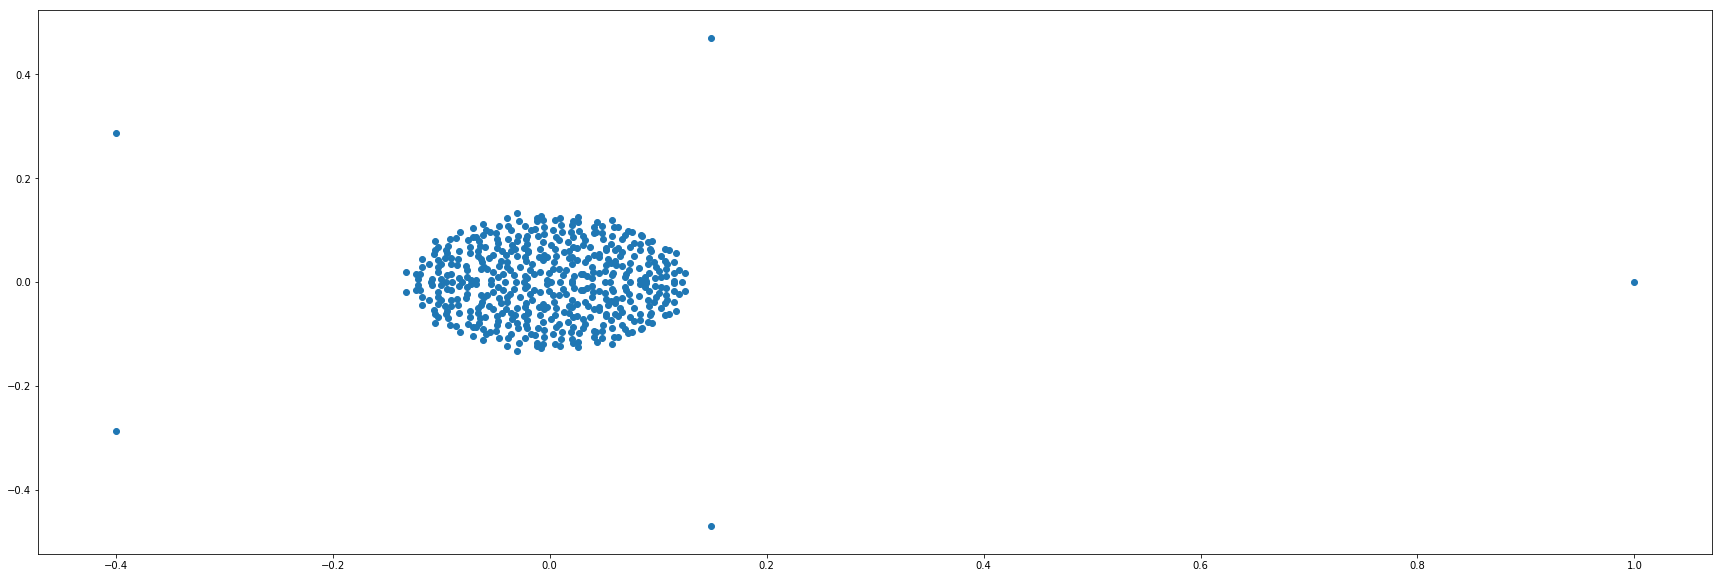

In [5]:
plt.scatter(np.real(values), np.imag(values))
plt.show()

/home/simon/virtualenvs/graph_problems/lib/python3.5/site-packages/pandas/plotting/_misc.py:108: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=0.0, right=0.0
  ax.set_xlim(boundaries_list[j])
/home/simon/virtualenvs/graph_problems/lib/python3.5/site-packages/pandas/plotting/_misc.py:109: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=0.0, top=0.0
  ax.set_ylim(boundaries_list[i])
/home/simon/virtualenvs/graph_problems/lib/python3.5/site-packages/pandas/plotting/_misc.py:100: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=0.0, right=0.0
  ax.set_xlim(boundaries_list[i])


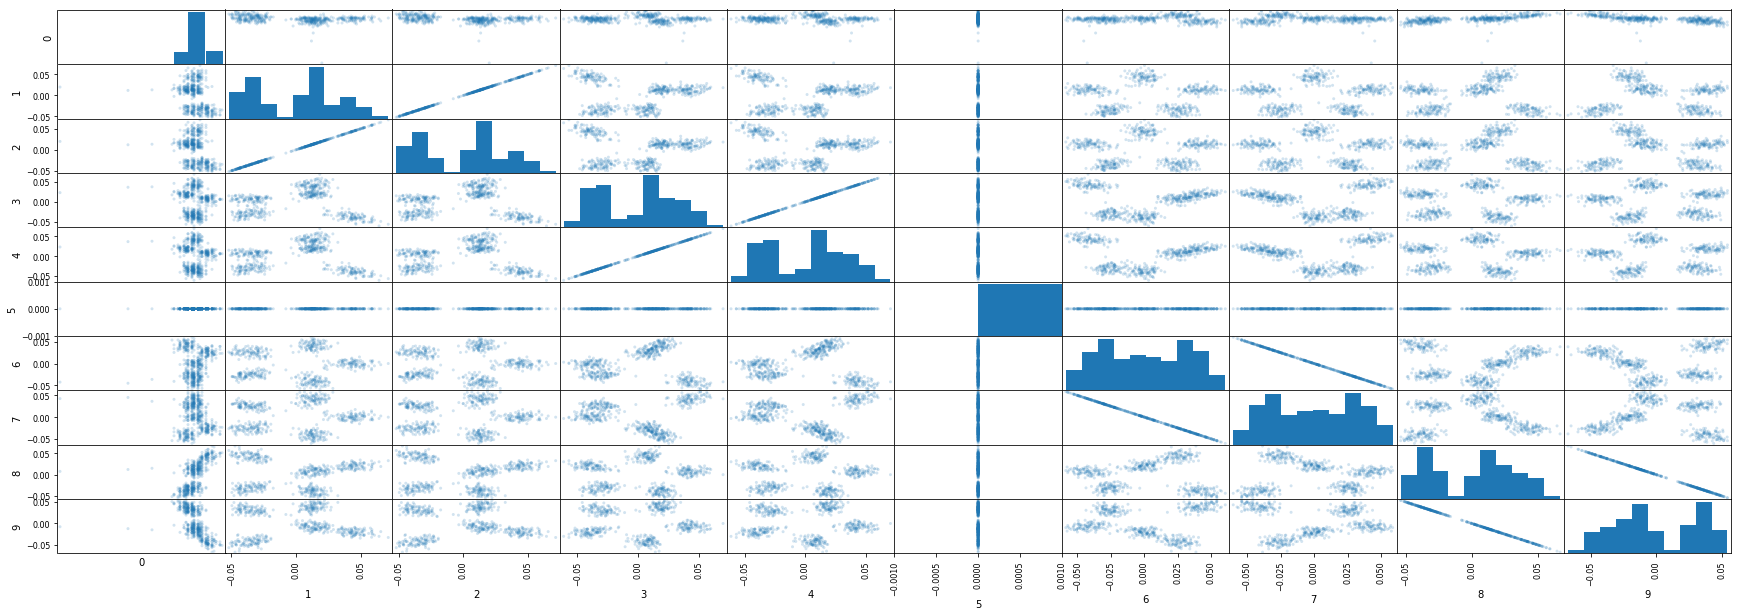

In [6]:
coords = np.asarray(vectors[:, 0:how_many_clusters])
coords = np.append(np.real(coords), np.imag(coords), axis=1)

df = pd.DataFrame(coords)
pd.plotting.scatter_matrix(df, alpha=0.2)
plt.show()

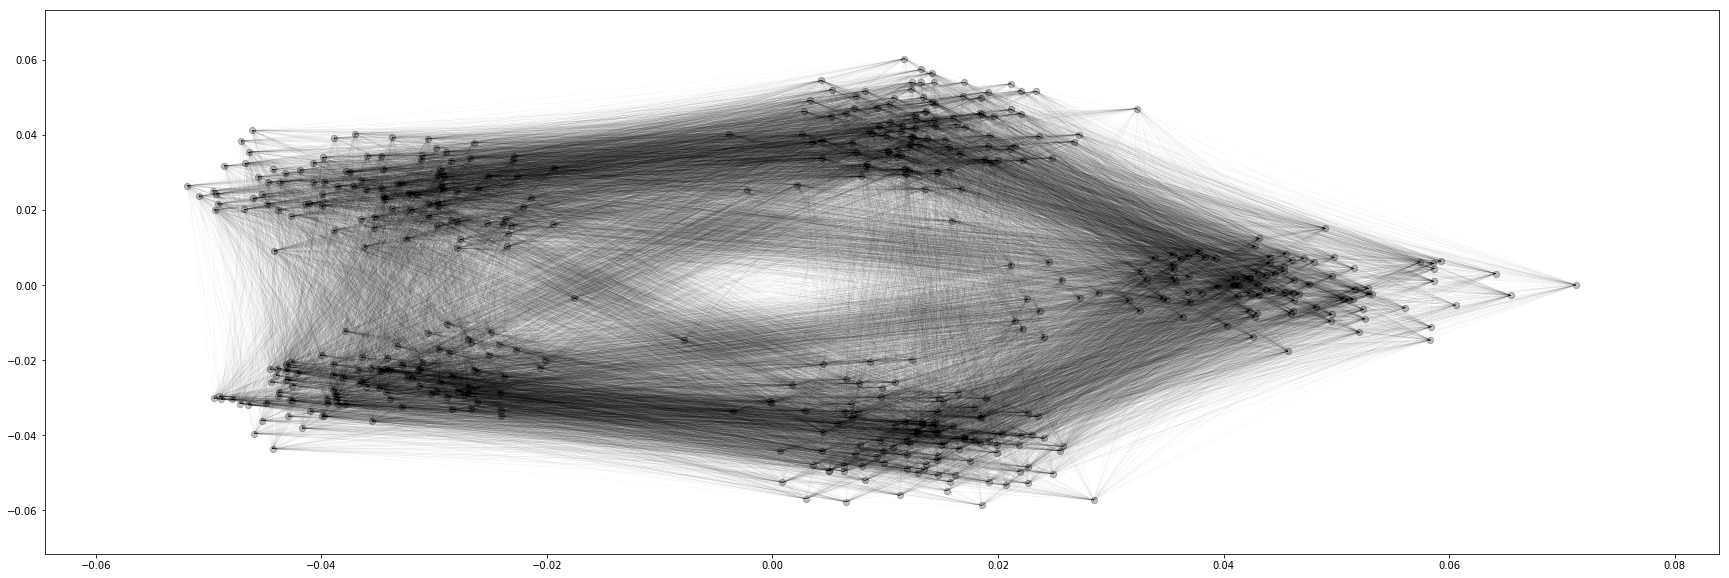

In [7]:
gs.plot_graph(coords[:, (1, 1 + how_many_clusters)],
              adj, edge_alpha = 0.2)